Для датасету

https://archive.ics.uci.edu/ml/datasets/wine+quality

побудувати модель лінійної регресії

Обов'язкові кроки:

первинний аналіз даних (відстуність пропусків, наявність категоріальних фіч, ...)
фича інжиніринг (побудувати  1-2 нові фічі)
масштабування фіч
поділ датасету на тренувальну, валідаційну та тестову частини
тренування базової моделі із дефолтними гіперпараметрами
підбір гіперпараметрів 
оцінка результатів

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures


In [2]:
redw_df = pd.read_csv('hw-5/wine+quality/winequality-red.csv', delimiter=';')
whitew_df = pd.read_csv('hw-5/wine+quality/winequality-white.csv', delimiter=';')
# Combine datasets and add a type column
redw_df['type'] = 'red'
whitew_df['type'] = 'white'
df = pd.concat([redw_df, whitew_df])
target = 'quality'
cat_features = ['type']
num_features = [ 'fixed acidity', 'volatile acidity',
                 'citric acid', 'residual sugar', 'chlorides',
                 'free sulfur dioxide', 'total sulfur dioxide',
                 'density', 'pH', 'sulphates', 'alcohol']
# Convert type feature into binary feature is_red
df['is_red'] = df['type'].map({"red": 1, "white": 0})
df.drop('type', axis=1, inplace=True)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,0
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,0


In [3]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
is_red                    int64
dtype: object

In [4]:
X_df = df.drop(target, axis=1)
y_df = df[target]

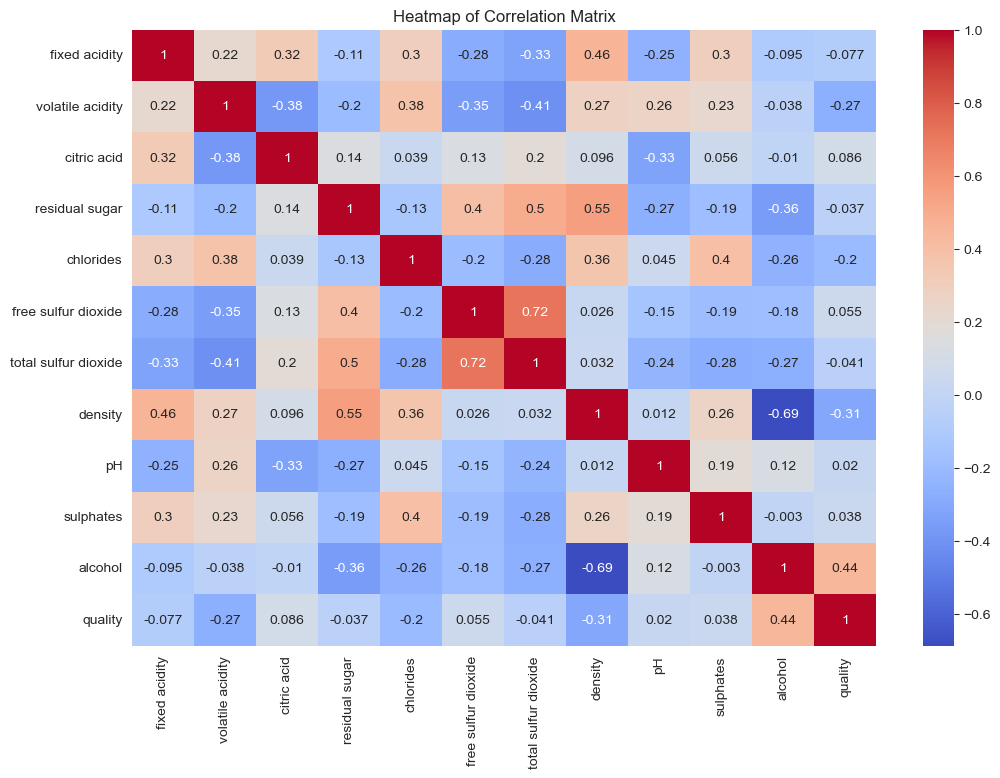

In [5]:
# Розглянемо кореляції між фічами і таргетом
# Оскільки значних кореляцій нема то ми можемо залилишити фічі як є
plt.figure(figsize=(12, 8))
correlation_matrix = df[num_features + [target]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [6]:
# # Distplot: Distribution plot for each feature
# for column in num_features:
#     plt.figure(figsize=(10, 6))
#     sns.histplot(df[column], kde=True)
#     plt.title(f'Distribution of {column}')
#     plt.show()

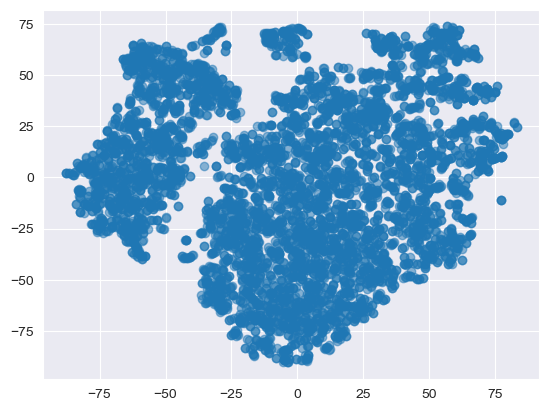

In [7]:
# TSNE without wine type
X = X_df.drop('is_red', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
tsne = TSNE(random_state=17)
tsne_repr = tsne.fit_transform(X_scaled)
plt.scatter(tsne_repr[:, 0], tsne_repr[:, 1], alpha=0.5);

# Тут ми бачимо 2 явних кластери, але скоріше за все це біле і червоне вина
# Тому краще провести TSNE до обєднання

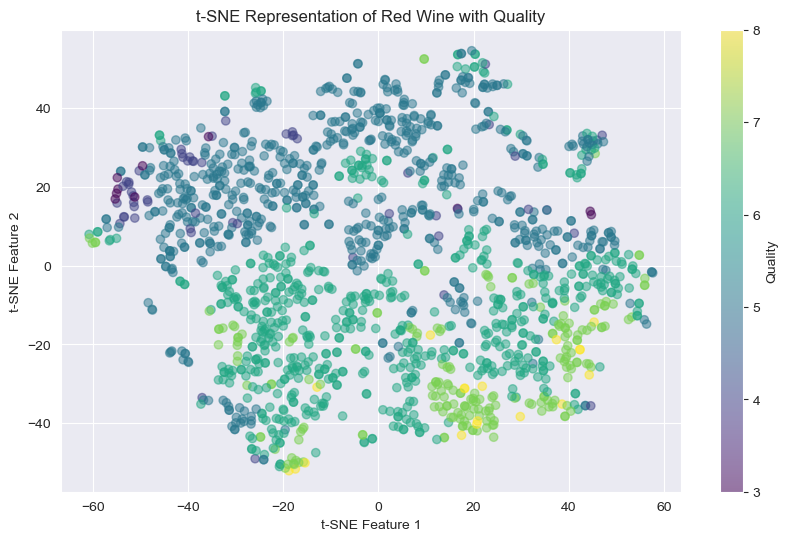

In [8]:
scaler = StandardScaler()
X_redw_df_scaled = scaler.fit_transform(redw_df.drop(columns=['type']))
tsne = TSNE(random_state=17)
red_tsne_repr = tsne.fit_transform(X_redw_df_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(red_tsne_repr[:, 0], red_tsne_repr[:, 1], c=redw_df['quality'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Quality')
plt.title('t-SNE Representation of Red Wine with Quality')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

# Тут ми накладаєм quality і з цього видоно що хороші вина переважно внизу а значить лінійна регресія має добре працювати з червоними винами 

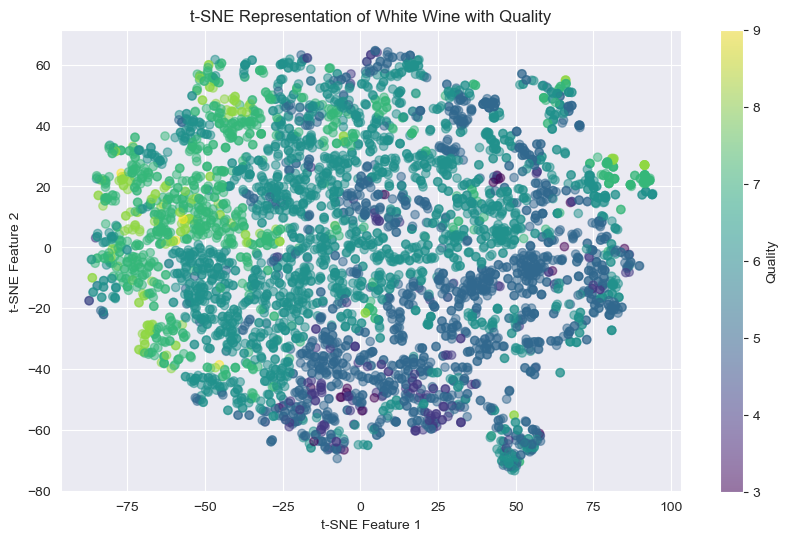

In [9]:
scaler = StandardScaler()
X_whitew_df_scaled = scaler.fit_transform(whitew_df.drop(columns=['type']))
tsne = TSNE(random_state=17)
white_tsne_repr = tsne.fit_transform(X_whitew_df_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(white_tsne_repr[:, 0], white_tsne_repr[:, 1], c=whitew_df['quality'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Quality')
plt.title('t-SNE Representation of White Wine with Quality')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

# Для білих вин також чітко можна побачити кластер хорошого вина 

In [10]:
def analyze_high_quality_cluster(df, tsne_repr, features, quality_threshold=7):
    # Select wines with high quality
    high_quality_wines = df[df['quality'] >= quality_threshold]
    # Get t-SNE representation for these wines
    high_quality_tsne = tsne_repr[df['quality'] >= quality_threshold]
    # Define the cluster area using the provided condition or a default one
    cluster_mask = (high_quality_tsne[:, 0] < 0) & (high_quality_tsne[:, 1] > 0)
    # Select wines in the high-quality cluster
    cluster_high_quality_wines = high_quality_wines[cluster_mask]
    # Plot feature distributions for high-quality cluster wines vs. all wines
    for feature in features:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[feature], label='All Wines', kde=True)
        sns.histplot(cluster_high_quality_wines[feature], label='High-Quality Cluster Wines', kde=True, color='red')
        plt.title(f'Distribution of {feature}')
        plt.legend()
        plt.show()


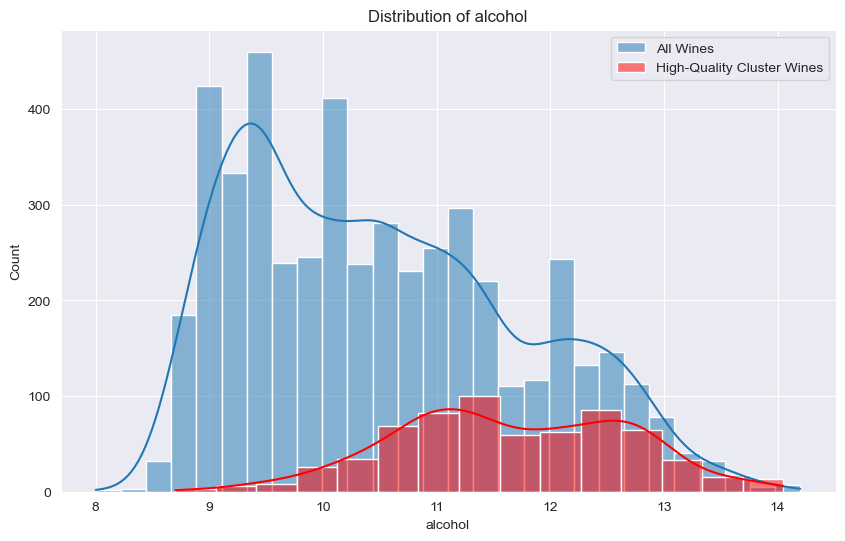

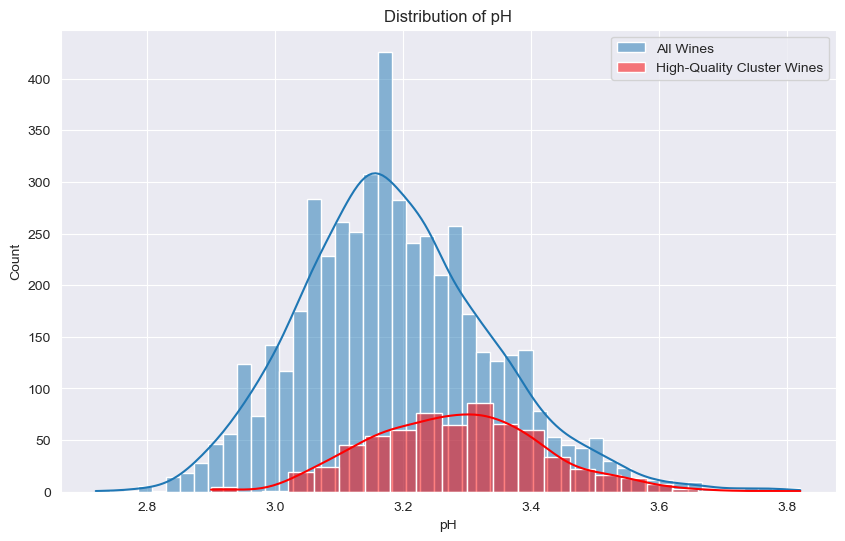

In [11]:
# Спробуємо знайти яка з фіч найбільше внесла вклад в якість білого вина
# Я вже проаналізував і з графіків видно що чим більше alcohol та pH тим краще
analyze_high_quality_cluster(whitew_df, white_tsne_repr, ['alcohol', 'pH'])

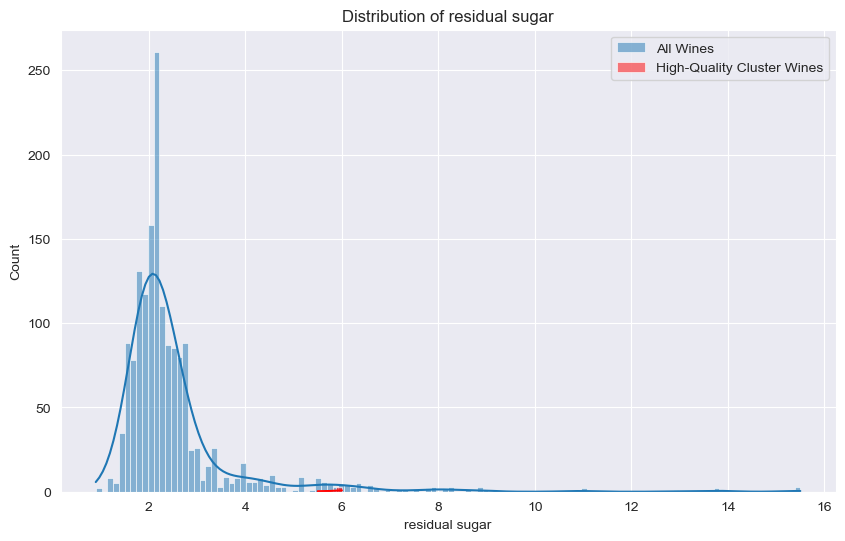

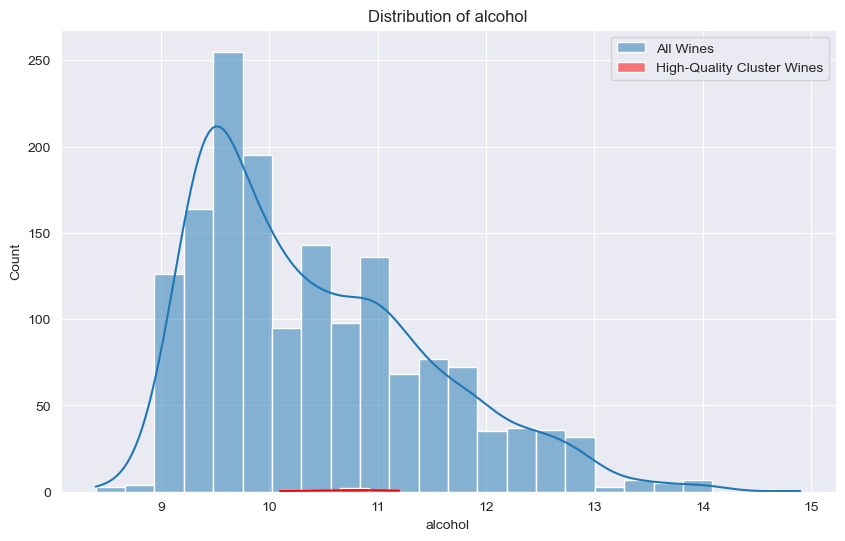

In [12]:
# Спробуємо знайти яка з фіч найбільше внесла вклад в якість червоного вина
# Проаналізувати червоні вина виявилось значно складніше так як відсоток хороших вин схоже у них досить низький
# Але все ж таки певна залежність від алкоголю і цукру є
analyze_high_quality_cluster(redw_df, red_tsne_repr, ['residual sugar', 'alcohol'], 7)

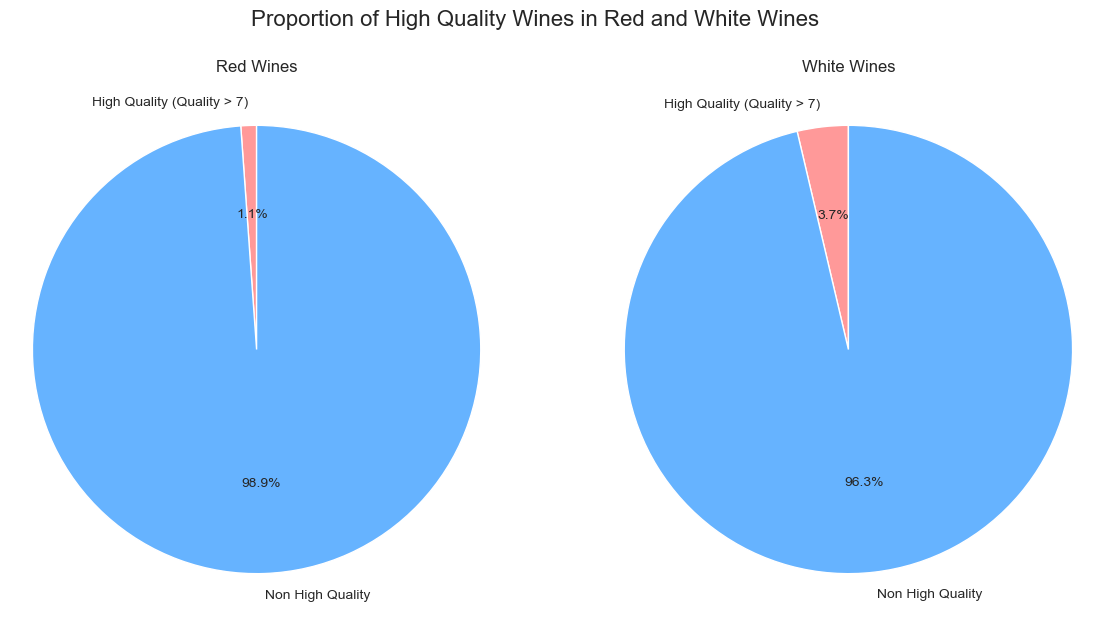

In [13]:
# Calculate counts for high-quality wines and total wines for each type
high_quality_threshold = 7
counts = df.groupby('is_red')['quality'].agg(
    total_samples='count',
    high_quality=lambda x: (x > high_quality_threshold).sum()
).reset_index()

# Add a column for non-high-quality wines
counts['non_high_quality'] = counts['total_samples'] - counts['high_quality']

# Calculate percentages
counts['high_quality_pct'] = counts['high_quality'] / counts['total_samples'] * 100
counts['non_high_quality_pct'] = counts['non_high_quality'] / counts['total_samples'] * 100

# Define labels for the pie charts
labels = ['High Quality (Quality > 7)', 'Non High Quality']

# Plot pie charts for red and white wines
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Pie chart for red wines
axes[0].pie([counts['high_quality_pct'][counts['is_red'] == 1].values[0],
             counts['non_high_quality_pct'][counts['is_red'] == 1].values[0]],
            labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[0].set_title('Red Wines')

# Pie chart for white wines
axes[1].pie([counts['high_quality_pct'][counts['is_red'] == 0].values[0],
             counts['non_high_quality_pct'][counts['is_red'] == 0].values[0]],
            labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
axes[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[1].set_title('White Wines')

# Add a main title to the figure
fig.suptitle('Proportion of High Quality Wines in Red and White Wines', fontsize=16)

# Show the plot
plt.show()

In [14]:
# На цих графіках помітно наскільки мало хорошого вина загалом і червоного зокрема
# Боюсь що сама регресія буде визначати практично все вино як погане тільки тому що воно червоне
# Тут би не завадило балансування, але побачимо як воно буде 
# Спочатку додамо нових фічей 

In [16]:
# Додамо Polynomial Features для 'alcohol', 'pH', 'residual sugar' 
features_to_transform = ['alcohol', 'pH', 'residual sugar']
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_df[features_to_transform])
poly_feature_names = poly.get_feature_names_out(features_to_transform)
poly_df = pd.DataFrame(X_poly, columns=poly_feature_names, index=X_df.index)
# Combine the polynomial features with the original DataFrame
X_df_poly = pd.concat([X_df, poly_df], axis=1)
X_df_poly

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,...,is_red,alcohol,pH,residual sugar,alcohol^2,alcohol pH,alcohol residual sugar,pH^2,pH residual sugar,residual sugar^2
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,...,1,9.4,3.51,1.9,88.36,32.994,17.86,12.3201,6.669,3.61
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,...,1,9.8,3.20,2.6,96.04,31.360,25.48,10.2400,8.320,6.76
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,...,1,9.8,3.26,2.3,96.04,31.948,22.54,10.6276,7.498,5.29
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,...,1,9.8,3.16,1.9,96.04,30.968,18.62,9.9856,6.004,3.61
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,...,1,9.4,3.51,1.9,88.36,32.994,17.86,12.3201,6.669,3.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,...,0,11.2,3.27,1.6,125.44,36.624,17.92,10.6929,5.232,2.56
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,...,0,9.6,3.15,8.0,92.16,30.240,76.80,9.9225,25.200,64.00
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,...,0,9.4,2.99,1.2,88.36,28.106,11.28,8.9401,3.588,1.44
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,...,0,12.8,3.34,1.1,163.84,42.752,14.08,11.1556,3.674,1.21


In [17]:
def evaluate_model(X_df, y_df):
    # 1. Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_df)

    # 2. Split the dataset
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_df, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # 3. Train a baseline model with default hyperparameters
    baseline_model = LinearRegression()
    baseline_model.fit(X_train, y_train)

    # Evaluate baseline model on the validation set
    y_val_pred = baseline_model.predict(X_val)
    print("Baseline Model R^2 Score on Validation Set: ", r2_score(y_val, y_val_pred))

    # 4. Hyperparameter tuning (using Ridge Regression as an example of a linear model with hyperparameters)
    param_grid = {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    }

    grid_search = GridSearchCV(estimator=Ridge(),
                               param_grid=param_grid,
                               cv=3,
                               n_jobs=-1,
                               verbose=2)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the validation set
    y_val_pred_best = best_model.predict(X_val)
    print("Best Model R^2 Score on Validation Set: ", r2_score(y_val, y_val_pred_best))

    # 5. Evaluate the best model on the test set
    y_test_pred = best_model.predict(X_test)
    print("Best Model R^2 Score on Test Set: ", r2_score(y_test, y_test_pred))

In [18]:
# Спробуєме побудувати модель для датафрейма з polynomial features
evaluate_model(X_df_poly, y_df)

Baseline Model R^2 Score on Validation Set:  0.2904104829655936
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Model R^2 Score on Validation Set:  0.28873163061523943
Best Model R^2 Score on Test Set:  0.26591919435999556


In [19]:
# Спробуєме побудувати модель для датафрейма з усіма винами
evaluate_model(X_df, y_df)

Baseline Model R^2 Score on Validation Set:  0.2898644516893749
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Model R^2 Score on Validation Set:  0.28968010084376716
Best Model R^2 Score on Test Set:  0.26400299423017226


In [20]:
# Спробуєме побудувати модель для датафрейма з червоними і білими винами окремо
evaluate_model(X_whitew_df_scaled, whitew_df['quality'])
evaluate_model(X_redw_df_scaled, redw_df['quality'])

Baseline Model R^2 Score on Validation Set:  1.0
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Model R^2 Score on Validation Set:  0.9999999999882613
Best Model R^2 Score on Test Set:  0.9999999999879077
Baseline Model R^2 Score on Validation Set:  1.0
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Model R^2 Score on Validation Set:  0.9999999998693379
Best Model R^2 Score on Test Set:  0.9999999998813968


In [21]:
# Отже з наведених вище даних зрозуміло що загальна модель для всіх вин дає дуже низький результат і краще тренувати 
# Окрему модель для кожного виду вина